# Import Library

In [0]:
# Handle table-like data 
import numpy as np
import pandas as pd

import time
# Model Algorithms
# we could use also tensor flow, there are multiple implementations of word2vec
# from gensim.models import word2vec

# Modelling Helpers, see above the description
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter

import re

%matplotlib inline
sns.set()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
import warnings
warnings.filterwarnings("ignore")

# Read Json file and examine basic information of data

In [0]:
recipe = pd.read_json('train.json')

In [0]:
recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
id             39774 non-null int64
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [0]:
recipe.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


# Define fuction for Clean data (Ingredients column)

In [0]:
def clean_recipe(recipe):
    # To lowercase
    recipe = [ str.lower(i) for i in recipe ]

    # Remove some special characters
    # Individuals replace have a very good performance
    # http://stackoverflow.com/a/27086669/670873
    def replacing(i):
        i = i.replace('&', '').replace('(', '').replace(')','')
        i = i.replace('\'', '').replace('\\', '').replace(',','')
        i = i.replace('.', '').replace('%', '').replace('/','')
        i = i.replace('"', '')
        
        return i
    
    # Replacing characters
    recipe = [ replacing(i) for i in recipe ]
    
    # Remove digits
    recipe = [ i for i in recipe if not i.isdigit() ]
    recipe = list(map(lambda x: re.sub(r"[0-9]", "", x), recipe))

    # Stem ingredients
    recipe = [ stemmer.lemmatize(i) for i in recipe ]
    
    #white space
    recipe = [ i.strip() for i in recipe]

    return recipe

# Most freuqent ingredients

In [0]:
stemmer = WordNetLemmatizer()

In [0]:
bags_of_words = [ Counter(clean_recipe(recipe)) for recipe in recipe.ingredients ]
sumbags = sum(bags_of_words, Counter())

In [0]:
df = pd.DataFrame(sumbags, index=['count']).T
df.reset_index(inplace = True)
df.columns = ['ingredients', 'count']

In [0]:
df = df.sort_values(by = 'count', ascending=False)

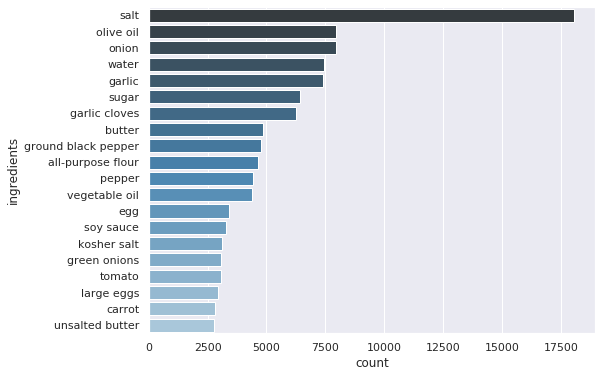

In [0]:
plt.figure(figsize = (8,6))
sns.barplot(y = 'ingredients', x = 'count', data=df.iloc[:20,:], palette='Blues_d')

# Count Cuisine menu

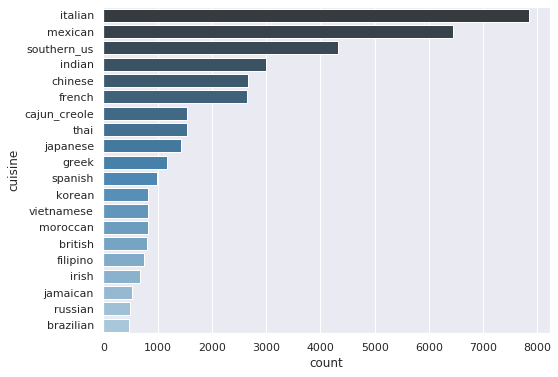

In [0]:
plt.figure(figsize = (8,6))
sns.countplot(y = 'cuisine', data=recipe, order = recipe['cuisine'].value_counts().index, palette='Blues_d')

# Clean Ingredients column

In [0]:
recipe['ingredients'] = recipe['ingredients'].apply(lambda x: clean_recipe(x))

In [0]:
recipe['ingredients'] = recipe['ingredients'].apply('|'.join)

recipe.head()

,id,cuisine,ingredients
0,10259,greek,romaine lettuce|black olives|grape tomatoes|ga...
1,25693,southern_us,plain flour|ground pepper|salt|tomato|ground b...
2,20130,filipino,egg|pepper|salt|mayonaise|cooking oil|green ch...
3,22213,indian,water|vegetable oil|wheat|salt
4,13162,indian,black pepper|shallot|cornflour|cayenne pepper|...


# Average number of ingredients

In [0]:
all_num_ing = 0
cui_num_ing = {}
cui_count = {}

for i in recipe.index:
  count = len(recipe.loc[i,'ingredients'].split('|'))
  all_num_ing += count
  if recipe.loc[i, 'cuisine'] not in cui_num_ing:
    cui_num_ing[recipe.loc[i, 'cuisine']] = count
    cui_count[recipe.loc[i, 'cuisine']] = 1
  else:
    cui_num_ing[recipe.loc[i, 'cuisine']] += count
    cui_count[recipe.loc[i, 'cuisine']] += 1

In [0]:
cui_mean_ing = {}
for i in cui_count.keys():
  cui_mean_ing[i] = cui_num_ing[i]/cui_count[i]

In [0]:
pd_avg_cui.sort_values(0, ascending=False)

,index,0
18,moroccan,12.909866
3,indian,12.705961
11,vietnamese,12.675152
12,cajun_creole,12.617076
10,thai,12.545809
4,jamaican,12.214829
8,chinese,11.982791
17,korean,11.284337
7,mexican,10.877446
5,spanish,10.423660


Average number of food ingredients is 10.76771257605471


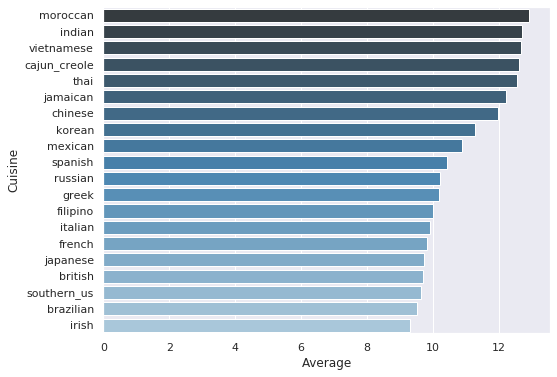

In [0]:
pd_avg_cui = pd.DataFrame().from_dict(cui_mean_ing, orient='index').reset_index().sort_values(0, ascending=False)
plt.figure(figsize = (8,6))
print('Average number of food ingredients is {}'.format(all_num_ing/recipe.shape[0]))
sns.barplot(x = 0, data = pd_avg_cui, y = 'index', palette='Blues_d')
plt.ylabel('Cuisine')
plt.xlabel('Average')
plt.show()

In [0]:
pd_avg_cui 

,index,0
0,greek,10.182128
1,southern_us,9.634954
2,filipino,10.000000
3,indian,12.705961
4,jamaican,12.214829
5,spanish,10.423660
6,italian,9.909033
7,mexican,10.877446
8,chinese,11.982791
9,british,9.708955


# stack each cuisine's ingredients

In [0]:
cuisine_dict = {}
for i in recipe.index:
    if recipe.loc[i, 'cuisine'] not in cuisine_dict:
        cuisine_dict[recipe.loc[i, 'cuisine']] = recipe.loc[i, 'ingredients']
    else:
        cuisine_dict[recipe.loc[i, 'cuisine']] += "|" + recipe.loc[i, 'ingredients']

In [0]:
cuisine_ingredients = pd.DataFrame.from_dict(cuisine_dict, orient='index', columns=['ingredients'])
cuisine_ingredients

,ingredients
greek,romaine lettuce|black olives|grape tomatoes|ga...
southern_us,plain flour|ground pepper|salt|tomato|ground b...
filipino,egg|pepper|salt|mayonaise|cooking oil|green ch...
indian,water|vegetable oil|wheat|salt|black pepper|sh...
jamaican,plain flour|sugar|butter|egg|fresh ginger root...
spanish,olive oil|salt|medium shrimp|pepper|garlic|cho...
italian,sugar|pistachio nuts|white almond bark|flour|v...
mexican,olive oil|purple onion|fresh pineapple|pork|po...
chinese,low sodium soy sauce|fresh ginger|dry mustard|...
british,greek yogurt|lemon curd|confectioners sugar|ra...


# Fit TF-IDF
use cuisines as document

In [0]:
ing_tokenizer = (lambda x: x.split('|'))

vectorizer = TfidfVectorizer(lowercase=True, tokenizer = ing_tokenizer, min_df = 2)
X = vectorizer.fit_transform(cuisine_ingredients['ingredients'], y = cuisine_ingredients.index)

In [0]:
ingredients = vectorizer.get_feature_names()
ingredients_idf = vectorizer.idf_

In [0]:
X_dense = X.todense()
X_dense = X_dense
X_dense.shape

(20, 4108)

In [0]:
embedded = pd.DataFrame(X_dense, columns= ingredients, index = cuisine_ingredients.index) 
embedded.head()

,accent,achiote powder,acorn squash,active dry yeast,adobo,adobo sauce,adobo seasoning,adzuki beans,agar,agave nectar,aged balsamic vinegar,aged cheddar cheese,ahi,ahi tuna steaks,aioli,ajinomoto,ajwain,alaskan king crab legs,albacore,albacore tuna in water,alcohol,ale,aleppo pepper,alfalfa sprouts,alfredo sauce,all beef hot dogs,all potato purpos,all purpose seasoning,all purpose unbleached flour,all-purpose flour,allspice,allspice berries,almond,almond butter,almond extract,almond filling,almond flour,almond liqueur,almond meal,almond milk,...,yardlong beans,yeast,yeast extract,yellow bean sauce,yellow bell pepper,yellow cake mix,yellow corn,yellow corn meal,yellow crookneck squash,yellow curry paste,yellow food coloring,yellow hominy,yellow lentils,yellow miso,yellow mustard,yellow mustard seeds,yellow onion,yellow peas,yellow peppers,yellow rice,yellow rock sugar,yellow split peas,yellow squash,yellow summer squash,yellow tomato,yellowfin tuna,yoghurt,yolk,young coconut meat,yuca,yucca,yukon gold,yukon gold potatoes,zaatar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
greek,0.0,0.000000,0.000000,0.004610,0.000000,0.000000,0.000000,0.000000,0.000000,0.001958,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.001440,0.001948,0.0,0.000000,0.001784,0.000000,0.001612,0.073266,0.005875,0.000000,0.003917,0.000000,0.002662,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001612,0.000000,0.0,0.017750,0.000000,0.00000,0.000000,0.001538,0.00000,0.000000,0.000000,0.000000,0.0,0.003428,0.000000,0.010990,0.000000,0.000887,0.000000,0.0,0.003301,0.001775,0.000000,0.0,0.0,0.010840,0.000000,0.000000,0.000000,0.000000,0.0,0.003224,0.0,0.003075,0.001784,0.003568,0.006475,0.034435,0.0
southern_us,0.0,0.000000,0.000825,0.007201,0.001067,0.001861,0.000000,0.000000,0.000533,0.002215,0.000629,0.000629,0.0,0.0,0.000465,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000497,0.000931,0.000000,0.0,0.000000,0.000000,0.000577,0.008856,0.289322,0.003797,0.000000,0.001899,0.000465,0.006596,0.000697,0.002452,0.000629,0.001491,0.001491,...,0.000000,0.000521,0.000000,0.0,0.003728,0.007495,0.00173,0.079759,0.000497,0.00000,0.002484,0.001395,0.000000,0.0,0.008493,0.002792,0.017284,0.000000,0.000287,0.000533,0.0,0.000000,0.004302,0.001491,0.0,0.0,0.001401,0.001312,0.000000,0.000000,0.000000,0.0,0.002084,0.0,0.000994,0.000577,0.000000,0.000000,0.003315,0.0
filipino,0.0,0.009538,0.001880,0.007923,0.004862,0.002121,0.002431,0.000000,0.002431,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.003179,0.000000,0.0,0.0,0.0,0.0,0.000000,0.002121,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.035613,0.000000,0.000000,0.000000,0.000000,0.001307,0.000000,0.000000,0.000000,0.002265,0.000000,...,0.002431,0.002374,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.006794,0.000000,0.000000,0.0,0.003366,0.000000,0.031296,0.000000,0.000000,0.000000,0.0,0.000000,0.001307,0.000000,0.0,0.0,0.000000,0.000000,0.003179,0.000000,0.002869,0.0,0.002374,0.0,0.000000,0.000000,0.000000,0.000000,0.006475,0.0
indian,0.0,0.000000,0.001239,0.008454,0.000000,0.000466,0.000000,0.000000,0.000000,0.001267,0.000000,0.000000,0.0,0.0,0.000466,0.000000,0.007683,0.0,0.0,0.0,0.0,0.000000,0.001398,0.000000,0.0,0.000698,0.000000,0.000000,0.000782,0.035562,0.002852,0.000000,0.011090,0.000466,0.000287,0.000000,0.001403,0.000000,0.000498,0.001990,...,0.000000,0.004173,0.000698,0.0,0.002297,0.000000,0.00000,0.000740,0.000000,0.00063,0.004478,0.000000,0.004807,0.0,0.000370,0.009318,0.033191,0.000698,0.000862,0.000000,0.0,0.010682,0.000574,0.000498,0.0,0.0,0.074014,0.000000,0.000000,0.000000,0.000000,0.0,0.007042,0.0,0.000000,0.000000,0.000000,0.000000,0.009957,0.0
jamaican,0.0,0.000000,0.000000,0.003160,0.000000,0.002960,0.003394,0.003668,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.001657,0.063272,0.106708,0.019845,0.000000,0.000000,0.001825,0

## Ingredients that most representative each cuisine 
---

In [0]:
for i in embedded.index:
  print(i)
  print(embedded.loc[i].sort_values(ascending = False)[:6])
  print('-------------------------------------------------')

greek
salt                    0.419083
olive oil               0.369262
feta cheese crumbles    0.304018
dried oregano           0.248817
feta cheese             0.230427
garlic cloves           0.186096
Name: greek, dtype: float64
-------------------------------------------------
southern_us
salt                 0.542182
butter               0.297135
all-purpose flour    0.289322
sugar                0.249546
buttermilk           0.181825
large eggs           0.176623
Name: southern_us, dtype: float64
-------------------------------------------------
filipino
salt         0.454337
garlic       0.350735
water        0.334548
onion        0.334548
soy sauce    0.270876
pepper       0.214758
Name: filipino, dtype: float64
-------------------------------------------------
indian
salt               0.458511
garam masala       0.336508
onion              0.283310
cumin seed         0.200162
ground turmeric    0.199199
water              0.194405
Name: indian, dtype: float64
----------------

## Find cuisine cluster

In [0]:
cuisine_count = recipe.groupby(by = 'cuisine').count()['id']
cuisine_count = cuisine_count.reset_index()
cuisine_count.columns = ['cuisine', 'count']

### Find optimal principal component

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
sc = StandardScaler()
embedded_sc = sc.fit_transform(embedded)

In [0]:
from sklearn.decomposition import PCA

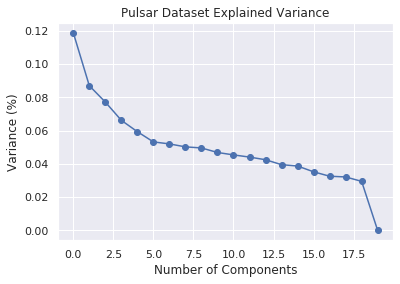

In [0]:
pca = PCA().fit(embedded_sc)
plt.figure()
plt.plot(pca.explained_variance_ratio_, '-o')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [0]:
pca = PCA(6).fit(embedded)
pca_cuisine = pd.DataFrame(pca.transform(embedded), index = embedded.index)

In [0]:
pca_cuisine_sc = pd.DataFrame(sc.fit_transform(pca_cuisine), index = embedded.index)

#### Clustering cuisine

choose number of k

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

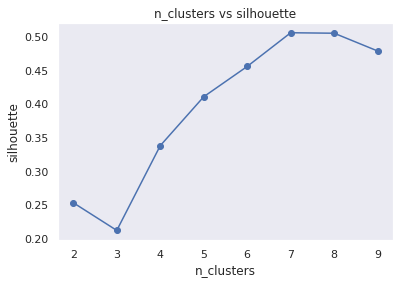

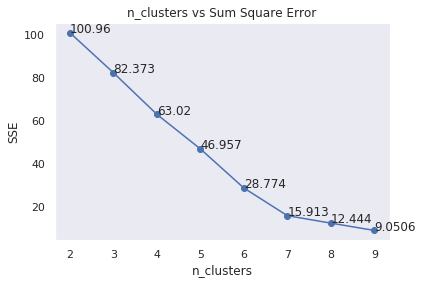

In [0]:
range_n_clusters = np.arange(2,10)
silhouette = []
sse = []
cluster_center = {}

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    clusterer = clusterer.fit(pca_cuisine_sc)
    silhouette.append(silhouette_score(pca_cuisine_sc, clusterer.predict(pca_cuisine_sc)))
    sse.append(clusterer.inertia_)
    cluster_center.update({'{}'.format(n_clusters):clusterer.cluster_centers_})
    
#plt.subplot(1, 2, 1)
plt.title('n_clusters vs silhouette')
plt.xlabel('n_clusters')
plt.ylabel('silhouette')
plt.grid()
plt.plot(range_n_clusters, silhouette, '-o')
plt.show() 
    
#plt.subplot(1, 2, 2)
plt.title('n_clusters vs Sum Square Error')
plt.xlabel('n_clusters')
plt.ylabel('SSE')
plt.grid()
plt.plot(range_n_clusters, sse, '-o')
for xy in zip(range_n_clusters, sse):
    plt.annotate('{:.5}'.format(xy[1]), textcoords='data', xy = xy)
plt.show()

From elbow method, I choose 4 clusters

In [0]:
clusterer = KMeans(n_clusters=7, random_state=0)
clusterer.fit(pca_cuisine_sc)
cuisine_cluster = clusterer.predict(pca_cuisine_sc)

In [0]:
pca_cuisine_sc = pca_cuisine.reset_index()
pca_cuisine_sc.columns = ['cuisine'] + [str(i) for i in range(6)]
pca_cuisine_sc = pd.merge(pca_cuisine_sc, cuisine_count, on = 'cuisine')
pca_cuisine_sc['cluster'] = cuisine_cluster

pca_cuisine_sc.head()

,cuisine,0,1,2,3,4,5,count,cluster
0,greek,-0.256010,-0.320655,-0.176217,-0.314121,-0.075080,0.019066,1175,1
1,southern_us,-0.301968,0.356913,0.102167,0.008202,0.031989,0.062157,4320,4
2,filipino,0.202343,0.030816,0.056997,0.107867,0.135434,-0.224610,755,2
3,indian,-0.001518,-0.212688,0.005823,0.479352,-0.296865,-0.163310,3003,6
4,jamaican,-0.025938,-0.016215,0.029723,0.216157,0.188848,-0.204445,526,2


### visualize cluster

In [0]:
fig = px.scatter(data_frame = pca_cuisine_sc, x = '0', y = '1',hover_name ='cuisine', text = 'cuisine',
                   size = 'count', color = 'cluster', size_max = 100)
fig.show()

## similar cuisine

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go

In [0]:
sim_matrix = pd.DataFrame(cosine_similarity(embedded, embedded), index = embedded.index, columns=embedded.index)

In [0]:
fig = go.Figure(data=go.Heatmap(
                   z=sim_matrix,
                   x=sim_matrix.index,
                   y=sim_matrix.index))
fig.show()

## most similar cuisine

In [0]:
most_sim = dict()
for i in sim_matrix.index:
  temp = sim_matrix.loc[i,:].sort_values(ascending = False)[1:2]
  most_sim[i] = [temp.index[0], temp.values[0]]
  # print(sim_matrix.loc[i,:].sort_values(ascending = False)[1:2].values)

In [0]:
most_sim_df = pd.DataFrame.from_dict(most_sim, orient='index').reset_index()
most_sim_df.columns = ['cuisine', 'most_sim_cuisine', 'cosine_sim']
most_sim_df.sort_values(by = 'cosine_sim', ascending=  False)

,cuisine,most_sim_cuisine,cosine_sim
9,british,irish,0.886444
16,irish,british,0.886444
1,southern_us,british,0.879702
10,thai,vietnamese,0.859692
11,vietnamese,thai,0.859692
19,russian,british,0.845167
14,french,british,0.824479
6,italian,spanish,0.819195
5,spanish,italian,0.819195
8,chinese,korean,0.772387


## using ingredients to score cuisine identity


In [0]:
def cuisine_predict(ingredients_list, embedded):
    return embedded.loc[:,ingredients_list].mean(axis = 1).sort_values(ascending = False)

In [0]:
i = 50
test = recipe.loc[i,'ingredients'].split('|')

print(test, recipe.loc[i, 'cuisine'], sep = '\n')
print('---------------------------------------------------')
cuisine_predict(test, embedded)[0:1].index[0]

['sirloin', 'mirin', 'yellow onion', 'low sodium soy sauce', 'water', 'corn oil', 'sugar', 'green onions', 'glass noodles', 'sake', 'shiitake', 'napa cabbage']
japanese
---------------------------------------------------


'japanese'

# Word2Vec

use number of ingredients as feature to predict cuisine

In [0]:
import gensim 

In [0]:
def ingredients_gen(ingredients):
    ing_list = list()
    for s in ingredients:
        ing_list.append(s.split('|'))
                        
    return ing_list

ingredient_sentence = ingredients_gen(recipe['ingredients'])

In [0]:
model = gensim.models.Word2Vec(sentences = ingredient_sentence, min_count=0,sg = 1)

In [0]:
ingredients_dict = {}
for vocab in model.wv.vocab.keys():
    ingredients_dict[vocab] = model.wv[vocab]
    
ingredients_w2v = pd.DataFrame(ingredients_dict).T
ingredients_w2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
romaine lettuce,0.070296,0.042974,0.144387,0.350002,-0.380772,0.446528,0.043951,-0.020686,-0.363918,-0.166579,0.343444,0.160452,0.481211,-0.340484,0.149992,0.032949,0.002887,0.004038,0.021929,-0.299522,0.038479,0.136624,-0.112055,0.021772,0.053997,0.209064,0.115556,-0.004835,0.121888,0.000596,-0.287847,-0.576241,0.210185,-0.287291,-0.123435,0.704759,0.150157,0.048928,0.393650,0.167587,...,-0.134003,0.147816,0.589535,0.032450,-0.018642,0.111126,0.413732,0.048843,0.174456,0.227423,0.358000,0.116254,-0.040467,0.113331,0.096111,0.526773,0.257231,-0.026443,-0.448676,-0.462574,-0.031153,-0.270740,-0.507103,0.591232,0.373541,-0.017265,-0.311365,0.359780,-0.128615,-0.064070,-0.266473,-0.277576,-0.469218,0.116084,0.362197,0.486717,-0.657538,-0.013288,-0.326044,-0.489517
black olives,0.010244,0.050478,0.480622,0.032550,-0.478840,0.369003,0.231350,-0.171458,-0.306375,-0.082480,0.875340,-0.149927,0.385086,-0.399019,0.232130,0.118008,-0.500055,-0.243357,-0.036658,-0.048231,0.047964,0.404577,-0.279965,-0.075977,0.096803,0.013817,-0.173582,0.051730,0.220033,-0.146725,-0.266815,-0.087172,0.305492,-0.231466,0.113561,0.521579,-0.048398,0.137703,0.280076,0.127849,...,-0.440272,-0.247063,0.485119,0.145022,0.061496,-0.148730,0.244259,0.282017,0.206395,0.100541,0.342754,-0.425943,-0.212821,0.063280,0.339643,0.608022,0.026636,-0.155296,-0.114879,-0.178543,0.275541,-0.042621,-0.579236,0.445780,0.090405,-0.347939,-0.320155,0.157702,-0.196376,-0.213402,0.033565,-0.419390,-0.236809,0.478605,0.346139,0.371750,-0.470877,0.470578,-0.333900,-0.414552
grape tomatoes,-0.152269,-0.119215,0.541466,0.215777,-0.357724,0.567012,0.280896,-0.029986,-0.371851,-0.383451,0.505141,0.316775,0.421542,-0.286231,-0.038468,0.091099,-0.122341,-0.372618,0.144111,-0.226447,0.228342,0.065690,-0.256031,-0.092374,0.291537,0.009174,-0.125386,-0.078034,0.283885,0.104770,-0.375122,-0.125474,0.385603,-0.303349,0.008080,0.302212,0.138692,0.088864,0.432570,0.054457,...,-0.187871,0.114619,0.537604,-0.066028,-0.088291,-0.091613,0.243479,0.295294,0.195537,0.271050,0.237724,0.177619,-0.166574,-0.015218,0.065296,0.415969,0.209581,-0.166034,-0.270227,-0.112928,0.045356,-0.043708,-0.557189,0.638268,-0.063891,-0.219532,-0.047649,0.371004,-0.281518,-0.309161,-0.282563,-0.338143,-0.249879,0.148325,0.172582,0.642175,-0.215928,0.110726,-0.087645,-0.467583
garlic,0.003438,0.223760,0.169033,-0.293065,-0.366609,0.354592,0.185964,0.068289,-0.325865,-0.326057,0.118763,0.311973,0.200380,-0.270601,-0.216596,0.369522,-0.522890,-0.254570,-0.145640,-0.746701,-0.174211,0.134729,-0.409551,-0.293827,-0.174183,0.007898,0.034639,-0.095452,-0.123446,-0.066706,0.089857,0.229534,0.183139,0.121009,0.208321,0.274366,-0.300757,-0.259095,-0.049199,-0.488680,...,-0.283468,-0.309373,0.443604,0.368055,0.439610,0.053468,0.342754,-0.012748,-0.098180,0.302946,0.242433,-0.057558,-0.206143,0.050431,0.271326,0.487047,0.463916,-0.531649,-0.101665,-0.280716,0.118680,-0.139820,-0.163185,0.408374,0.127785,0.128694,-0.099704,-0.165394,-0.046757,-0.279863,-0.316226,-0.269702,0.100622,0.416815,0.059344,0.489376,-0.445890,0.316008,-0.550498,-0.493856
pepper,-0.228366,0.316320,0.343361,-0.293417,-0.346192,-0.019394,0.446338,0.358964,-0.109972,-0.057987,0.244823,0.264322,-0.119515,-0.340528,0.170700,0.034426,-0.237643,0.079318,-0.221757,-0.424353,0.203391,0.092859,-0.182855,-0.139850,-0.280995,0.214070,-0.323670,-0.431491,-0.054585,-0.266357,-0.309274,-0.022565,0.570207,-0.164909,0.140173,0.152418,-0.306017,-0.140008,0.385314,-0.075765,...,-0.385856,-0.065957,0.168584,0.220311,-0.043692,-0.252974,0.026829,0.173146,0.256465,0.412668,0.118699,0.081097,-0.127387,-0.179753,0.893516,0.131754,-0.112762,-0.077467,0.533841,-0.179816,0.063073,0.109159,-0.443016,0.483791,-0.024521,-0.025985,-0.018065,0.027629,0.276441

## model example method

ingredients that don't belong in the given group.

In [0]:
model.wv.doesnt_match(['fish sauce', 'thai basil', 'grated parmesan cheese'])

'grated parmesan cheese'

most_similar ingredients

In [0]:
model.wv.most_similar(positive=['thai basil'], topn=5)

[('bird chile', 0.9516383409500122),
 ('thai chile', 0.9418554902076721),
 ('palm sugar', 0.940556526184082),
 ('vietnamese coriander', 0.9377093315124512),
 ('rice noodles', 0.9365001320838928)]

In [0]:
model.wv.most_similar(positive=['grated parmesan cheese'], topn=5)

[('parmesan cheese', 0.9075760841369629),
 ('romano cheese', 0.8573564887046814),
 ('freshly grated parmesan', 0.8453881144523621),
 ('marinara sauce', 0.8383197784423828),
 ('rigatoni', 0.816506564617157)]

In [0]:
model.wv.most_similar(positive=['thai basil', 'grated parmesan cheese'], topn=5)

[('treviso', 0.8463152647018433),
 ('langoustine', 0.8454477190971375),
 ('dungeness crabs', 0.8425118923187256),
 ('homemade meatballs', 0.8367322683334351),
 ('lowfat plain greekstyl yogurt', 0.8349822163581848)]

In [0]:
model.wv.most_similar(positive=['thai basil', 'grated parmesan cheese'],
                      negative = ['onion'], topn=5)

[('prosciutto', 0.5895729660987854),
 ('rice vermicelli', 0.5792638659477234),
 ('parmesan cheese', 0.5711351633071899),
 ('fish sauce', 0.5670448541641235),
 ('ragu sauce', 0.5665231347084045)]

In [0]:
sc = StandardScaler()
ingredients_w2v_sc = sc.fit_transform(ingredients_w2v)

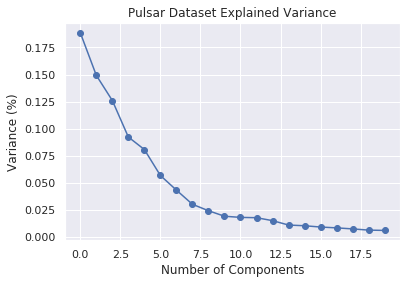

In [0]:
pca = PCA().fit(ingredients_w2v_sc)
plt.figure()
plt.plot(pca.explained_variance_ratio_[:20], '-o')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [0]:
ingredients_w2v_pca = PCA(9).fit_transform(ingredients_w2v_sc)

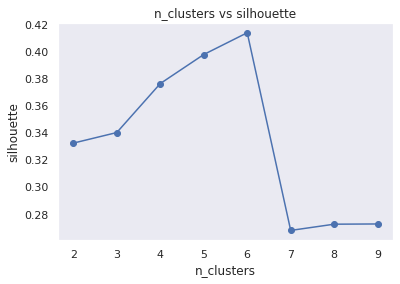

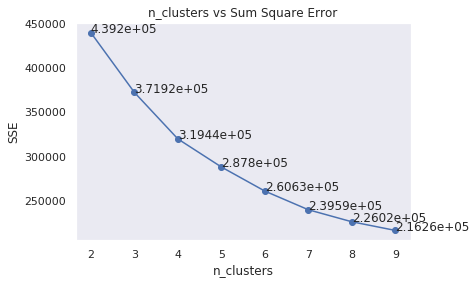

In [0]:
range_n_clusters = np.arange(2,10)
silhouette = []
sse = []
cluster_center = {}

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    clusterer = clusterer.fit(ingredients_w2v_pca)
    silhouette.append(silhouette_score(ingredients_w2v_pca, clusterer.predict(ingredients_w2v_pca)))
    sse.append(clusterer.inertia_)
    cluster_center.update({'{}'.format(n_clusters):clusterer.cluster_centers_})
    
#plt.subplot(1, 2, 1)
plt.title('n_clusters vs silhouette')
plt.xlabel('n_clusters')
plt.ylabel('silhouette')
plt.grid()
plt.plot(range_n_clusters, silhouette, '-o')
plt.show() 
    
#plt.subplot(1, 2, 2)
plt.title('n_clusters vs Sum Square Error')
plt.xlabel('n_clusters')
plt.ylabel('SSE')
plt.grid()
plt.plot(range_n_clusters, sse, '-o')
for xy in zip(range_n_clusters, sse):
    plt.annotate('{:.5}'.format(xy[1]), textcoords='data', xy = xy)
plt.show()

In [0]:
clusterer = KMeans(n_clusters=6, random_state=101)
clusterer = clusterer.fit(ingredients_w2v_pca)

## Visualize with w2v

In [0]:
time_start = time.time()

tsne_result = TSNE(n_components=3, random_state=101, n_iter = 1000).fit_transform(ingredients_w2v_pca)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 337.63268089294434 seconds


In [0]:
tsne_w2v = pd.DataFrame(tsne_result, index = ingredients_w2v.index, columns=['0', '1', '2'])

tsne_w2v = tsne_w2v.reset_index()
tsne_w2v.columns = ['ingredients', '0', '1', '2']

tsne_w2v['kmean_cluster'] = clusterer.predict(ingredients_w2v_pca)
tsne_w2v.head()

,ingredients,0,1,2,kmean_cluster
0,romaine lettuce,9.627204,13.644958,-3.558582,3
1,black olives,10.221749,1.333008,14.149199,3
2,grape tomatoes,7.350049,0.932287,14.765005,2
3,garlic,6.917708,10.037664,4.660438,5
4,pepper,9.567980,7.916429,6.224704,3


Ingredients that appear close to each other mean that they've been used togather a lot

Focus on ingredients that far apart from its cluster

In [0]:
fig = px.scatter_3d(data_frame = tsne_w2v, x = '0', y = '1', z = '2',hover_name ='ingredients', color = 'kmean_cluster')
fig.show()

In [0]:
ingredients_dict = {}
for vocab in model.wv.vocab.keys():
    ingredients_dict[vocab] = model.wv[vocab]
    
ingredients_w2v_2 = pd.DataFrame(ingredients_dict).T
ingredients_w2v_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
romaine lettuce,-2.491791,-2.314828,2.020913,-0.816026,1.612553,-0.312579,0.760011,0.251424,-0.836073,-0.384638,1.074681,-0.398223,0.377966,1.132265,0.518403,-1.588867,-0.270990,0.300306,-0.488152,-0.145279
black olives,-1.530558,-2.400704,1.446563,-0.211723,0.892228,-1.376434,1.184153,-0.375242,-2.198717,0.367787,1.105913,-0.454287,1.143790,0.324347,-0.592658,-1.531605,0.102108,0.331378,0.120601,0.000109
grape tomatoes,-2.388322,-2.257532,1.995195,-0.409101,0.787591,-1.152125,0.495163,0.414860,-1.772613,0.023083,0.028137,-0.363074,0.642745,1.121122,0.483079,-0.490108,0.316965,-0.099509,-0.417617,0.002391
garlic,-0.434186,-1.676779,-1.985958,0.457780,-0.144216,-1.750123,0.744533,0.118232,-0.955985,1.001723,1.432191,-1.083121,1.392515,0.467238,0.902770,-1.255009,-1.460034,2.164348,-2.460835,0.192368
pepper,-1.151958,-1.461496,-0.296139,0.643960,0.332624,-1.542115,1.479609,0.798828,-0.798929,0.036638,-0.200145,0.317549,1.431837,-0.014329,-1.664155,0.215341,-1.054549,1.629135,0.271446,-0.167654


# Bring it all together

Suppose we want to open an fusion restaurant

We can choose cluster for ease of fusion

In [0]:
fig = px.scatter(data_frame = pca_cuisine_sc, x = '0', y = '1',hover_name ='cuisine', text = 'cuisine',
                   size = 'count', color = 'cluster', size_max = 100)
fig.show()

subset only 4 cuisine in the cluster

In [0]:
new_embedded = embedded.T.loc[:,['british', 'french', 'russian', 'southern_us']]

find ingredient that not used in these cuisine

In [0]:
no_ing = []
for i in new_embedded.index:
  if new_embedded.loc[[i], :].sum(axis = 1).all() == 0:
    no_ing.append(i)

In [0]:
new_embedded = new_embedded.drop(index = no_ing)
new_embedded.head()

,british,french,russian,southern_us
acorn squash,0.000000,0.001460,0.000000,0.000825
active dry yeast,0.015768,0.017136,0.066962,0.007201
adobo,0.000000,0.000000,0.000000,0.001067
adobo sauce,0.000000,0.000000,0.000000,0.001861
agar,0.000000,0.000944,0.008219,0.000533


In [0]:
for i in new_embedded.columns:
  print(i)
  print(new_embedded.loc[:,i].sort_values(ascending = False)[:6])
  print('-------------------------------------------------')

In [0]:
new_embedded_prob = new_embedded.copy()
for i in new_embedded_prob.columns:
  new_embedded_prob.loc[:,i] /= new_embedded_prob.loc[:,i].sum()

In [0]:
def gen_key_ingredient(prob = [1/4, 1/4, 1/4, 1/4], num_ing = 3):
  cuisine = ['british', 'french', 'russian', 'southern_us']
  ingredients = []
  for i in range(num_ing):
    c = np.random.choice(a = cuisine, p = prob, size = 1)
    ing = np.random.choice(new_embedded.loc[:,c].index, size = 1, p = new_embedded_prob.loc[:,c[0]].values)
    ingredients.append(ing[0])
  print('Keys ingredients are', ingredients)
  # print('cuisine score is\n', new_embedded.loc[ingredients, :].sum(axis = 0).sort_values(ascending = False))
  return ingredients

In [0]:
key = gen_key_ingredient(prob = [1/4, 1/4, 1/4, 1/4], num_ing = 3)

keys ingredients are ['butter', 'parsley', 'fine granulated sugar']


In [0]:
def gen_all_ingredients(key_ingredients, num_ing = 11):
  for i, j in model.wv.most_similar(positive= key_ingredients , topn=11 - len(key_ingredients)):
    key_ingredients.append(i)
  print('All ingredients are', key_ingredients)
  print('cuisine score is\n', new_embedded.loc[key_ingredients, :].sum(axis = 0).sort_values(ascending = False))

In [0]:
gen_all_ingredients(gen_key_ingredient([0, 0.8, 0, 0.2]))

keys ingredients are ['ground black pepper', 'all-purpose flour', 'port']
All ingredients are ['ground black pepper', 'all-purpose flour', 'port', 'dried lavender', 'savory', 'fines herbes', 'veal scallops', 'soft-shelled crabs', 'quail', 'toasted baguette', 'vermouth']
cuisine score is
 french         0.441050
southern_us    0.403480
british        0.389595
russian        0.325910
dtype: float64


In [0]:
key = gen_key_ingredient([0, 0.8, 0, 0.2])

ingredients are ['port', 'butter', 'ground white pepper']
cuisine score is
 southern_us    0.305329
british        0.286018
french         0.240825
russian        0.195457
dtype: float64
